# Data progress

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xlrd
from scipy import stats
import pandas as pd

In [2]:
cases = pd.read_csv('cases.csv')
cases.head()

,Unnamed: 0,12-Mar,13-Mar,14-Mar,15-Mar,16-Mar,17-Mar,18-Mar,19-Mar,20-Mar,...,24-Oct,25-Oct,26-Oct,27-Oct,28-Oct,29-Oct,30-Oct,31-Oct,1-Nov,2-Nov
0,Alabama,0,5,7,22,29,39,52,78,106,...,105971,107050,108017,109106,103790,105230,106559,108313,110007,110914
1,Alaska,0,1,1,1,1,3,6,9,12,...,6128,6644,6990,7302,7604,7932,8307,8740,9082,9425
2,Arizona,8,8,11,12,17,19,26,44,77,...,191378,192547,193169,194062,194834,195865,197205,198808,200333,200568
3,Arkansas,6,9,12,16,22,22,33,62,97,...,9544,9775,9580,9500,9315,9478,9809,10198,10433,10149
4,California,231,276,348,414,546,692,830,989,1184,...,422871,424662,425298,427681,429570,432183,434690,436869,439426,440873


In [3]:
states, days = cases.shape
print(states, days)

50 237


In [4]:
cases.loc[1]

Unnamed: 0    Alaska
12-Mar             0
13-Mar             1
14-Mar             1
15-Mar             1
               ...  
29-Oct          7932
30-Oct          8307
31-Oct          8740
1-Nov           9082
2-Nov           9425
Name: 1, Length: 237, dtype: object

<ipython-input-58-86b9e5458c0e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


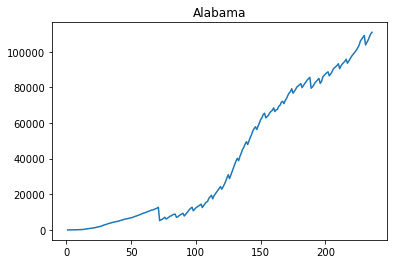

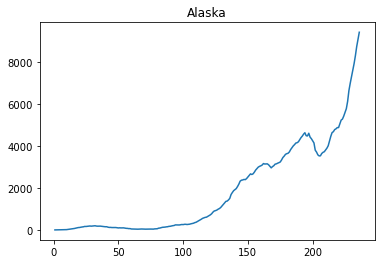

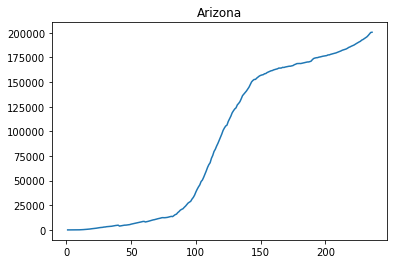

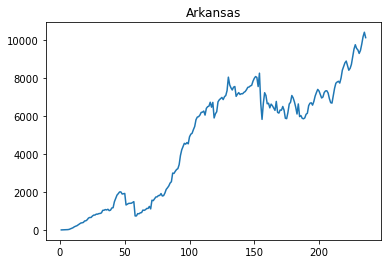

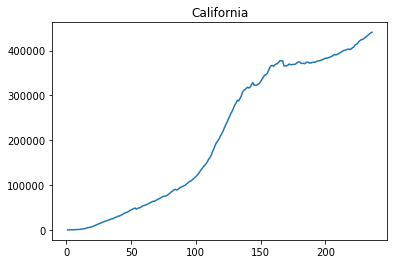

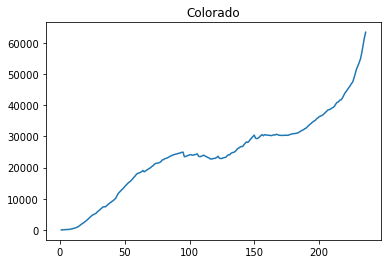

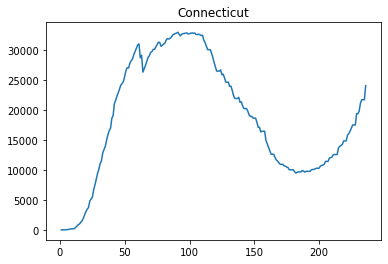

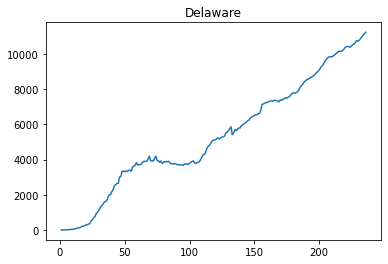

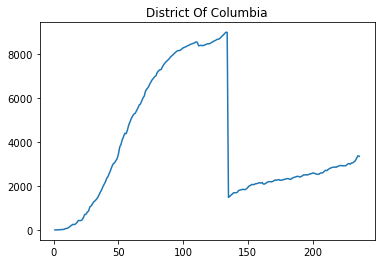

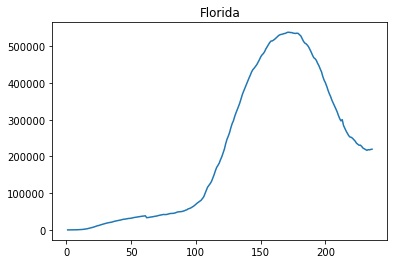

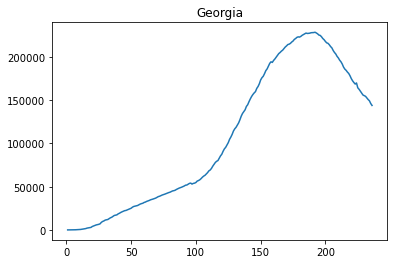

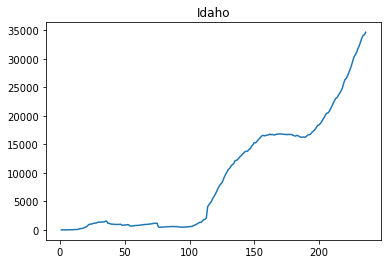

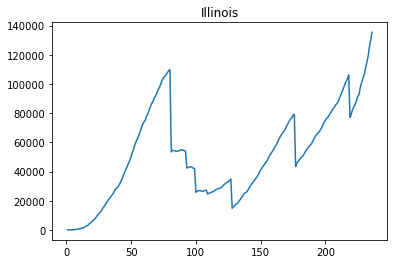

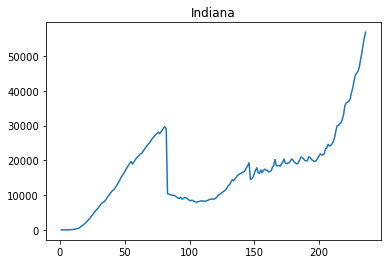

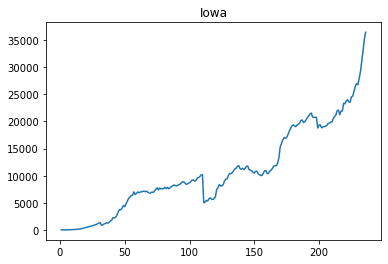

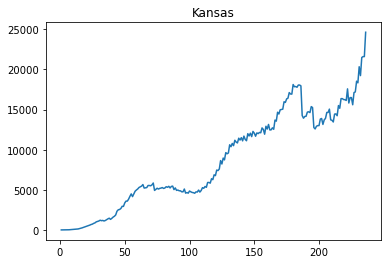

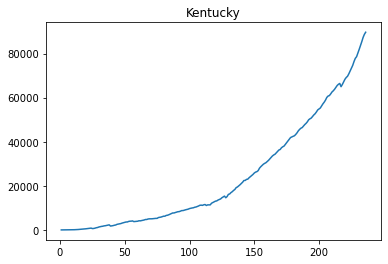

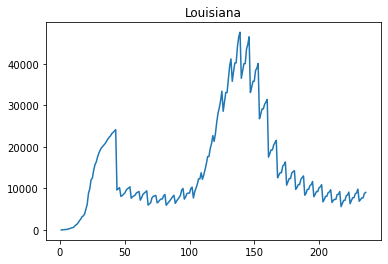

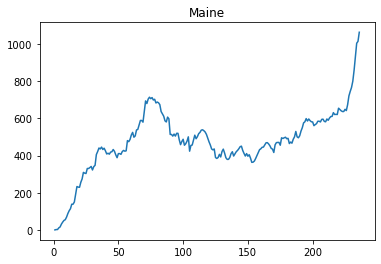

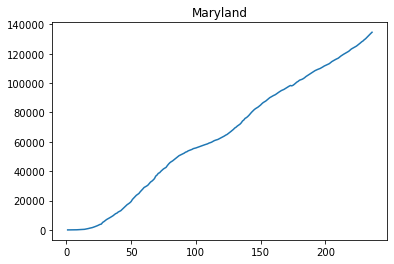

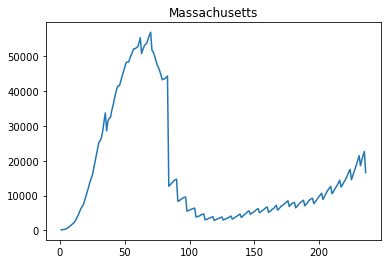

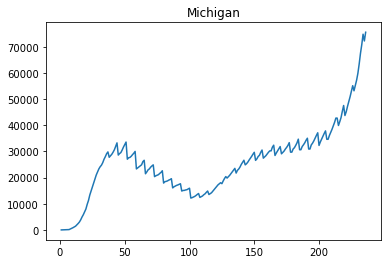

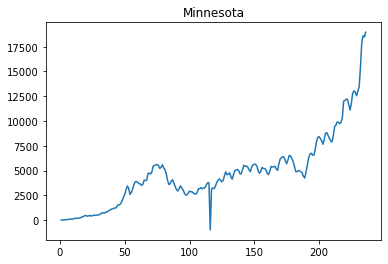

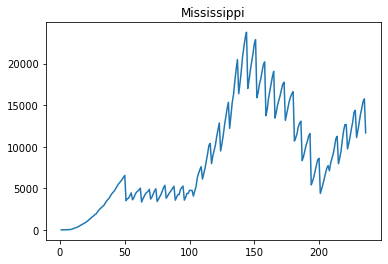

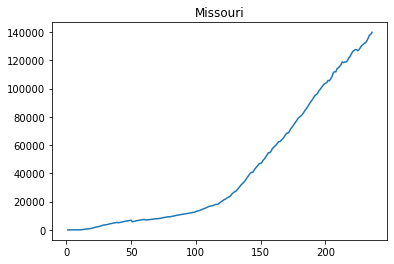

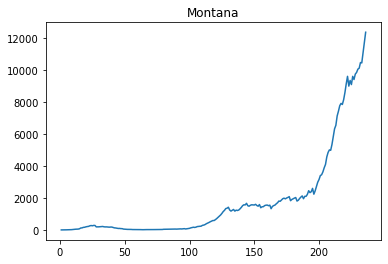

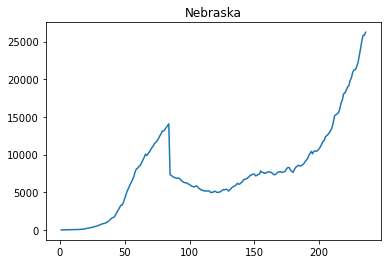

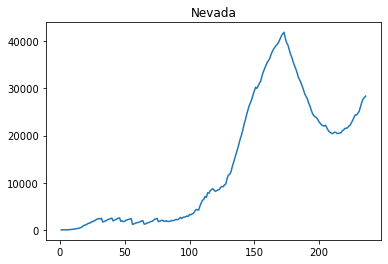

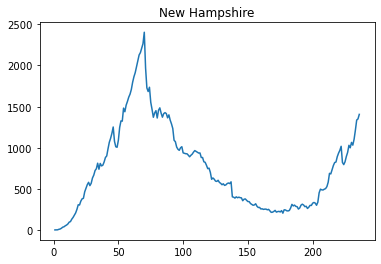

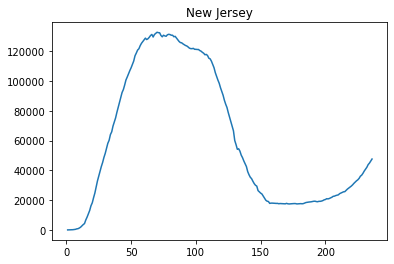

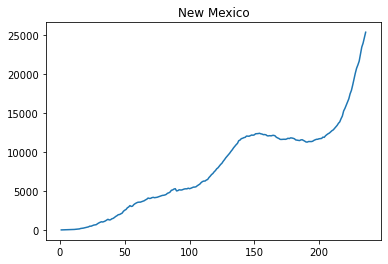

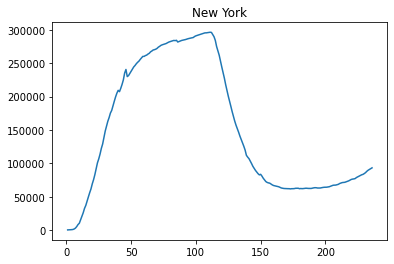

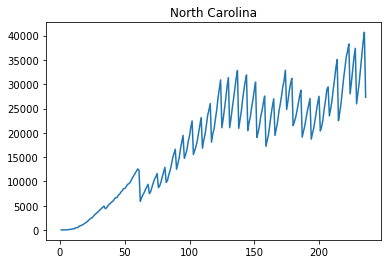

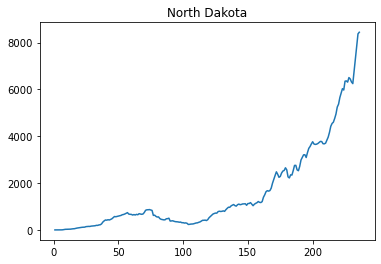

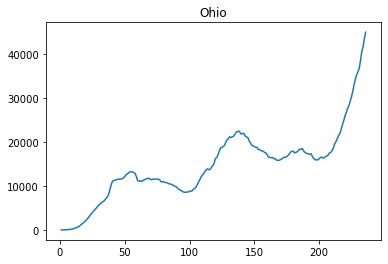

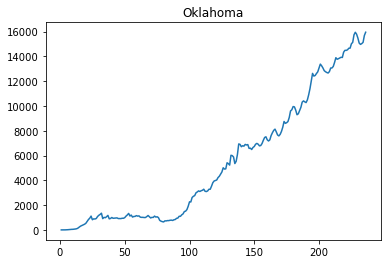

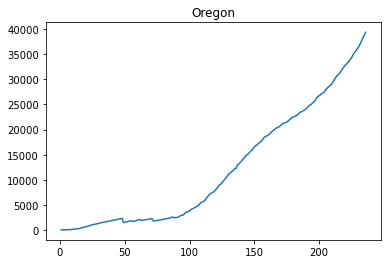

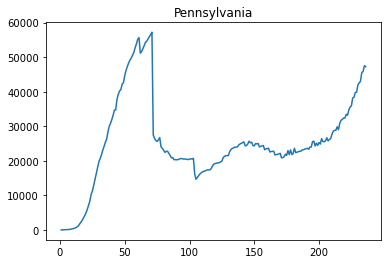

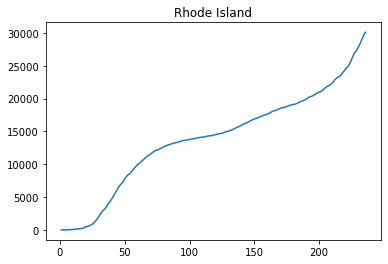

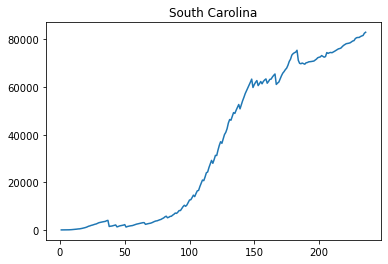

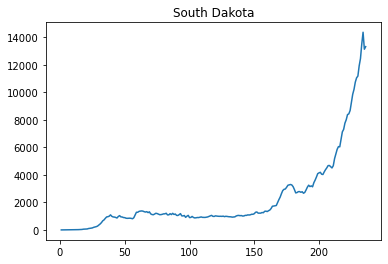

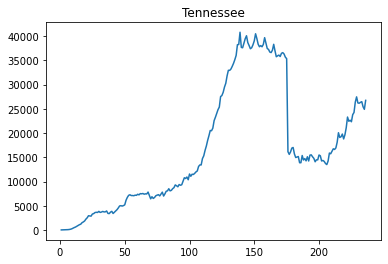

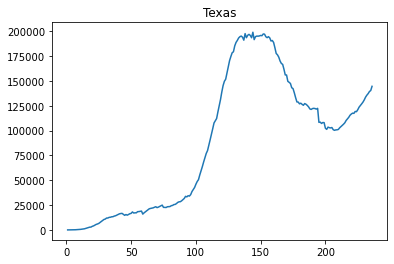

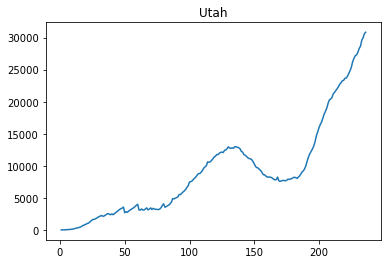

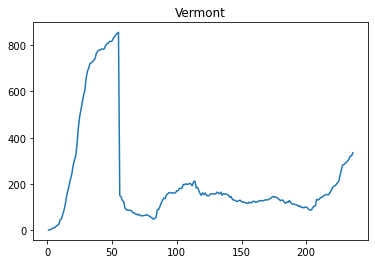

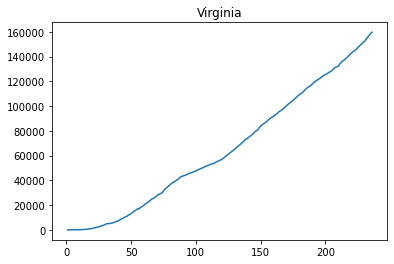

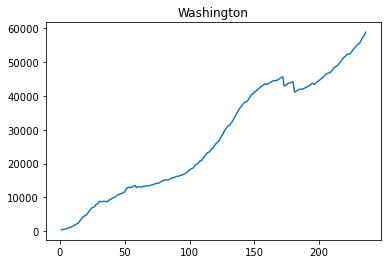

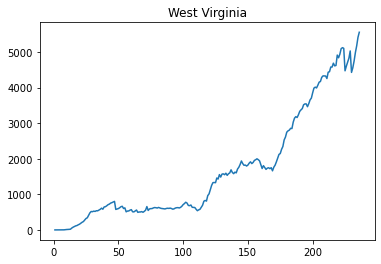

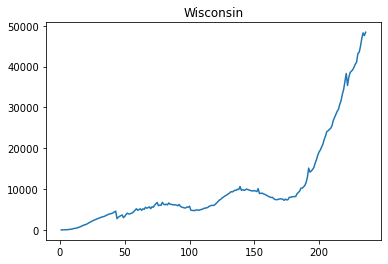

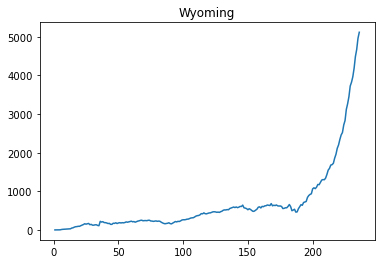

In [58]:
for i in range(states):
    plt.figure()
    plt.plot(range(1, days), cases.loc[i][1:])
    plt.title(cases.loc[i][0])
    

### The early evolution of I people:
\begin{equation}
I = I_0 e^{(\beta S - \gamma) t}
\end{equation}
Assuming that the S value is constant.

### Find the suited range:
From the first non-zero element since the trend is increasing.

In [5]:
def find_range(cases):
    begin = 0 
    end = days
    for i in range(1, days):
        if cases[i] != 0 and begin == 0:
            begin = i
        if begin != 0:
            if i <= 5: shift = 1
            else: shift = i - 5

            if cases[i] < np.average(cases[shift:i]):
                end = i
                break
    return begin, end

### Fit the equation:
\begin{equation}
I = I_0 e^{(\beta S - \gamma) t}
\end{equation}

In [6]:
def fit_equation(cases): 
    begin, end = find_range(cases)
    betaSgamma = np.polyfit(np.arange(begin, end), np.log(list(cases[begin:end])), 0)
    return betaSgamma

In [7]:
fit_equation(cases.loc[0])
# find_range(cases.loc[0])

array([7.5821771])

### Find $\beta$, given $\gamma$ and population of the state:

In [8]:
pop = pd.read_csv('population.csv')
pop.head()

,State,Population
0,Alabama,4888949
1,Alaska,738068
2,Arizona,7123898
3,Arkansas,3020327
4,California,39776830


In [9]:
gamma = 1/14
def find_beta(cases, i):
    population = pop.loc[i][1]
    return (fit_equation(cases) + gamma)/population

In [10]:
find_beta(cases.loc[7], 7)


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


array([6.27188637e-06])

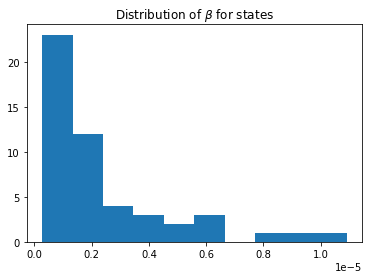

In [11]:
beta = np.zeros(states)
for i in range(0, states):
    beta[i] = find_beta(cases.loc[i], i)

plt.hist(beta)
plt.title('Distribution of $\u03B2$ for states')
plt.savefig('beta_dist.png')

### Gini Coefficient

In [12]:
gini = pd.read_csv('gini.csv')
gini.head()

,State,Gini Coefficient
0,Alabama,0.4847
1,Alaska,0.4081
2,Arizona,0.4713
3,Arkansas,0.4719
4,California,0.4899


In [13]:
gini.shape

(50, 2)

Text(0.5, 0, '$β$')

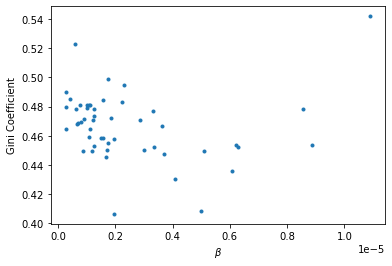

In [14]:
plt.plot(beta, gini['Gini Coefficient'], '.')

plt.ylabel('Gini Coefficient')
plt.xlabel('$\u03B2$')

Finding $t_peak$ given $\beta$, population of the state, and $\gamma$, which is the time that the peak of infected people comes in.


In [15]:
def find_peak(cases, i):
    beta = find_beta(cases, i)
    population = pop.loc[i][1]
    def SIR(k,t):
        S = k[0]
        I = k[1]
        R = k[2]
        dSdt = -1*beta*I*S
        dIdt = beta*I*S - gamma*I
        dRdt = gamma*I
        return [dSdt, dIdt, dRdt]

    #Initial conditions and t range
    step = 0.05
    t = np.arange(0,50, step)
    k0=[population,1, 0]

    #Solve
    k = odeint(SIR,k0,t)

    t_p = np.where(k[:,1] == max(k[:,1]))[0][0] * step
    I_p = max(k[:,1]) / population
    return t_p, I_p


In [17]:
a, b = find_peak(cases.loc[i], i)
print(a, b)

5.050000000000001 0.8998912348073399


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


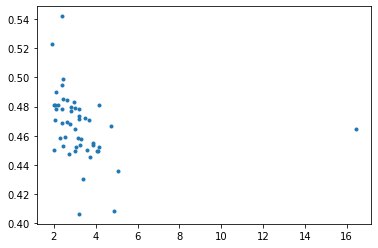

In [18]:
t_p = np.zeros(states)
I_p = np.zeros(states)
for i in range(states):
    t_p[i], I_p[i] = find_peak(cases.loc[i], i)


plt.plot(t_p, gini['Gini Coefficient'], '.')

-0.016299152804866043 0.5161880395380422


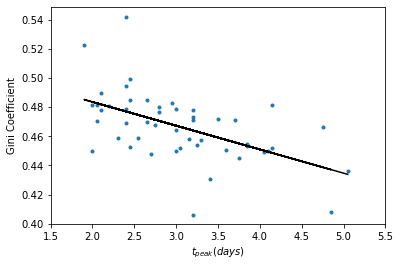

In [40]:
plt.plot(t_p, gini['Gini Coefficient'], '.')
plt.xlim(1.5, 5.5)
plt.ylabel('Gini Coefficient')
plt.xlabel('$t_{peak}(days)$')

#deleting the part data!
X = np.delete(t_p, 35, axis = 0)
Y = list(gini['Gini Coefficient'])
Y = np.delete(Y, 35, axis = 0)
a, b = np.polyfit(X, Y, 1)
print(a, b)
plt.plot(X, (a * X + b), c = 'black')

plt.savefig('tpeak.png')

# print(np.shape([X, Y]))
# print(np.zip(X, Y))
np.savetxt('tpeak.csv', [X, Y], delimiter=',')

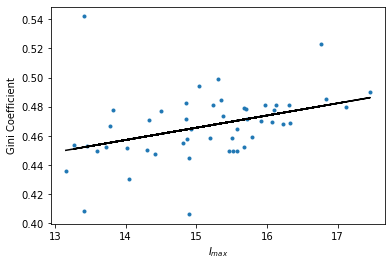

In [33]:
plt.plot(np.log(I_p), gini['Gini Coefficient'], '.')
plt.ylabel('Gini Coefficient')
plt.xlabel('$I_{max}$')

# X = np.delete(t_p, 35, axis = 0)
X = np.log(I_p)
Y = list(gini['Gini Coefficient'])
# Y = np.delete(Y, 35, axis = 0)
a, b = np.polyfit(X, Y, 1)
plt.plot(X, (a * X + b), c = 'black')

plt.savefig('Imax.png')

In [32]:
reg = np.cov(X, Y) / (np.std(X) * np.std(Y))
reg

array([[4.60314170e+01, 3.87075923e-01],
       [3.87075923e-01, 2.26200471e-02]])

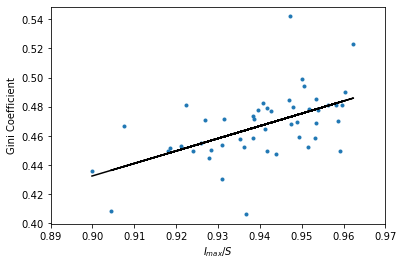

In [42]:
plt.plot(I_p, gini['Gini Coefficient'], '.')
plt.ylabel('Gini Coefficient')
plt.xlabel('$I_{max}/S$')
plt.xlim(0.89, 0.97)

X = np.delete(I_p, 35, axis = 0)
# X = I_p
Y = list(gini['Gini Coefficient'])
Y = np.delete(Y, 35, axis = 0)
a, b = np.polyfit(X, Y, 1)
plt.plot(X, (a * X + b), c = 'black')

plt.savefig('Imax_normal.png')

np.savetxt('Imax.csv', [X, Y], delimiter=',')

In [30]:
reg = np.cov(X, Y) / (np.std(X) * np.std(Y))
reg

array([[0.65230351, 0.5587813 ],
       [0.5587813 , 1.59757027]])